ガウス混合モデル
==============

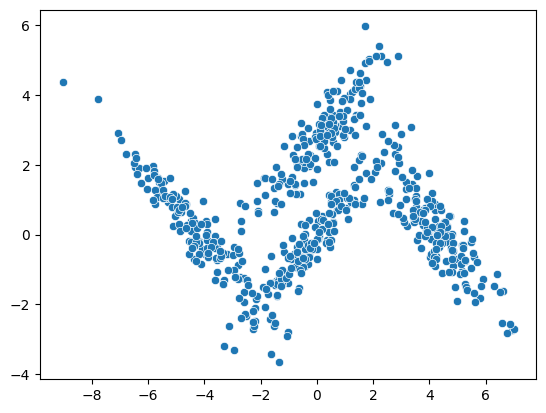

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import seaborn as sns

n_samples = 600
centers = [[-3, -3], [0, 0], [3, 3], [-2, 2]]
cluster_std = [[2, 0.3], [0.3, 2], [1.5, 0.4], [0.4, 1.5]]

X, _ = make_blobs(n_samples=n_samples,
                  centers=centers,
                  cluster_std=cluster_std,
                  random_state=42)

theta = np.pi / 4
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                           [np.sin(theta), np.cos(theta)]])
X = np.dot(X, rotation_matrix)

sns.scatterplot(x=X[:, 0], y=X[:, 1])
plt.show()

このようなデータがあり、クラスタリングしたいとします。

{ref}`k-means<k-means>`でクラスタリングしてみましょう。

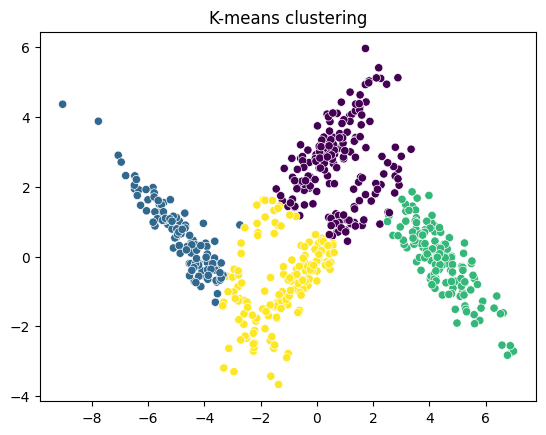

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Xに図中の座標データ

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

sns.scatterplot(x=X[:, 0], y=X[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-means clustering')
plt.show()

自分が思ったようにクラスタリングされたでしょうか？

k-means法では、クラスタの中心を平均値を用いて繰り返し更新して決めるため、クラスターは円形になります。
そのため、今回のようなデータに対してはうまくいきません。

本章で学ぶガウス混合モデル（GMM）は、このようなデータに対して思ったようにクラスタリングしてくれます。

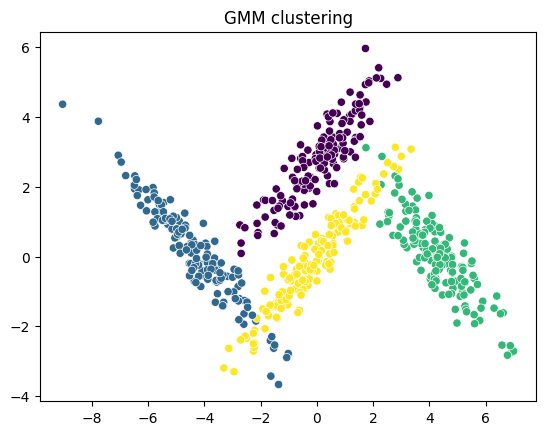

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(X)

sns.scatterplot(x=X[:, 0], y=X[:, 1], c=gmm_labels, cmap='viridis')
plt.title('GMM clustering')
plt.show()

k-means法ではデータの距離でクラスタリングしますが、
GMMは分布によってクラスタリングします。

GMMは複数の正規分布（ガウス分布）の重ね合わせでデータの分布を表現し、クラスタリングを行う手法です。
k-means法が各データポイントを明確に1つのクラスタに割り当てるのに対し、GMMは各データポイントが各クラスタに属する確率を計算します。

GMMは以下のような状況で有用です。

- データが正規分布に従っている
- クラスタの形が楕円形である
- クラスタの大きさや密度が異なる

## ガウス混合モデルの数学的表現

偏差値は成績が正規分布に従うという仮定を元に計算されています。
しかし、その過程を満たさない分布もありそうです。

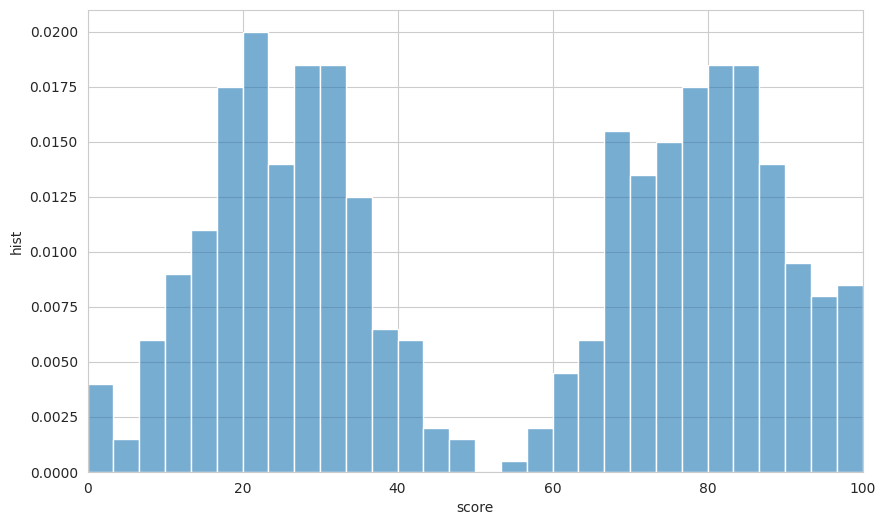

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

a = np.random.normal(25, 10, 300)
b = np.random.normal(80, 10, 300)

total = np.clip(np.concatenate([a, b]), 0, 100)
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.histplot(data=total, bins=30, stat="density", alpha=0.6)
plt.xlabel('score')
plt.ylabel('hist')
plt.xlim(0, 100)
plt.show()

GMMは、K個の正規分布の重み付き和として以下のように表現されます。

$p(x) = \sum_{k=1}^K \pi_k \mathcal{N}(x|\mu_k, \Sigma_k)$

ここで：
- $\pi_k$は各成分（クラスタ）の混合重み（$\sum_{k=1}^K \pi_k = 1$）
- $\mu_k$は各成分の平均ベクトル
- $\Sigma_k$は各成分の共分散行列
- $\mathcal{N}(x|\mu_k, \Sigma_k)$は多変量正規分布

## EMアルゴリズム

GMMのパラメータ推定には、Expectation-Maximization（EM）アルゴリズムが使用されます。

```{prf:algorithm} GMMのEMアルゴリズム
:label: gmm-algo

1. パラメータ$\pi_k$, $\mu_k$, $\Sigma_k$を初期化
2. 以下を収束するまで繰り返す
   1. E-step: 各データポイントの各クラスタへの所属確率を計算
      $\gamma_{ik} = \frac{\pi_k \mathcal{N}(x_i|\mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(x_i|\mu_j, \Sigma_j)}$
   2. M-step: パラメータを更新
      - $\pi_k^{new} = \frac{1}{N}\sum_{i=1}^N \gamma_{ik}$
      - $\mu_k^{new} = \frac{\sum_{i=1}^N \gamma_{ik}x_i}{\sum_{i=1}^N \gamma_{ik}}$
      - $\Sigma_k^{new} = \frac{\sum_{i=1}^N \gamma_{ik}(x_i-\mu_k^{new})(x_i-\mu_k^{new})^T}{\sum_{i=1}^N \gamma_{ik}}$
```

## GMMの実装例

先ほどと同じirisデータセットを使用して、GMMによるクラスタリングを実装してみましょう。

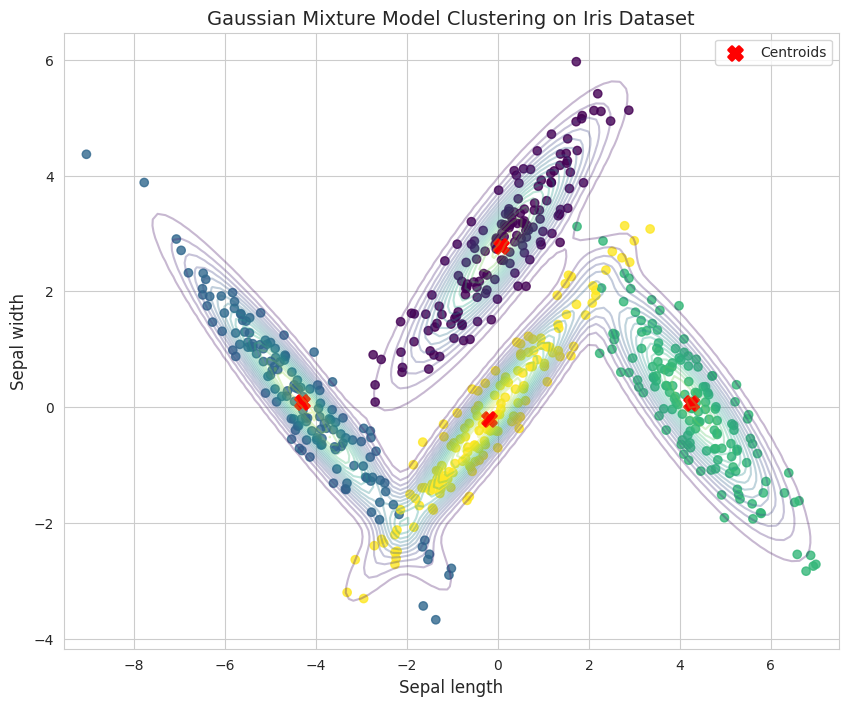

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# GMMモデルの作成と学習
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(X)

# クラスタの予測
labels = gmm.predict(X)

# 等高線用のグリッド点を生成
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
XY = np.column_stack([xx.ravel(), yy.ravel()])

# 確率密度を計算
Z = gmm.score_samples(XY)
Z = Z.reshape(xx.shape)

# プロット
plt.figure(figsize=(10, 8))

# 確率密度の等高線をプロット
plt.contour(xx, yy, np.exp(Z), levels=20, cmap='viridis', alpha=0.3)

# データポイントをプロット
scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.8)

# 各ガウス分布の平均をプロット
means = gmm.means_
plt.scatter(means[:, 0], means[:, 1], c='red', marker='X', s=100, 
            linewidth=2, label='Centroids')

plt.xlabel('Sepal length', fontsize=12)
plt.ylabel('Sepal width', fontsize=12)
plt.title('Gaussian Mixture Model Clustering on Iris Dataset', fontsize=14)
plt.legend()
plt.show()

このプロットでは、データポイントの色分けに加えて、各ガウス分布の確率密度を等高線で表示しています。
これにより、クラスタの形状や重なり具合を視覚的に理解できます。

## k-means法とGMMの比較

GMMはk-means法と比べて以下のような特徴があります：

長所：
- クラスタの形状が楕円形の場合に適している
- クラスタの大きさや密度が異なる場合でも対応可能
- 各データポイントの所属確率が得られる
- クラスタの重なりを自然に扱える

短所：
- 計算コストが高い
- パラメータ数が多く、過学習のリスクがある
- 初期値の選択に敏感
- 収束が遅い場合がある


## k-meansクラスタリングの欠点

k-meansクラスタリングの概念は素晴らしく聞こえますよね?理解が簡単で、実装も比較的容易で、多くのユースケースに適用できます。しかし、注意すべきいくつかの欠点と制限があります。

先ほどの収入-支出の例を見てみましょう。K-meansアルゴリズムはうまく機能しているように見えますね?しかし - よく見ると、作成されたすべてのクラスタが円形であることに気づくでしょう。これは、クラスタの重心が平均値を使用して反復的に更新されるためです。

では、ポイントの分布が円形でない次の例を考えてみましょう。このデータにk-meansクラスタリングを使用するとどうなると思いますか?依然として円形にデータポイントをグループ化しようとします。それは良くありません!k-meansは正しいクラスタを識別できません。

したがって、データポイントにクラスタを割り当てる異なる方法が必要です。

そこで、距離ベースのモデルの代わりに、分布ベースのモデルを使用します。

そしてここでガウス混合モデルの登場です!

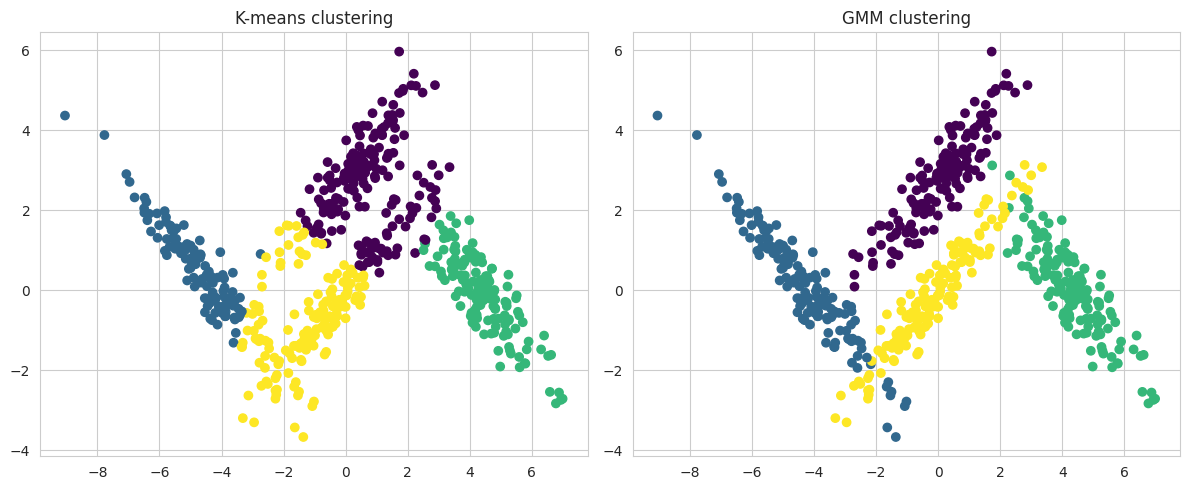

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# 4つの楕円形クラスターを生成
n_samples = 600
centers = [[-3, -3], [0, 0], [3, 3], [-2, 2]]
# それぞれのクラスターの標準偏差を調整して傾きを作る
cluster_std = [[2, 0.3], [0.3, 2], [1.5, 0.4], [0.4, 1.5]]

X, y = make_blobs(n_samples=n_samples,
                  centers=centers,
                  cluster_std=cluster_std,
                  random_state=42)

# 回転行列を使って傾きを加える
theta = np.pi / 4  # 45度の回転
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                           [np.sin(theta), np.cos(theta)]])
X = np.dot(X, rotation_matrix)

# K-meansとGMMで分類
kmeans = KMeans(n_clusters=4, random_state=42)
gmm = GaussianMixture(n_components=4, random_state=42)

kmeans_labels = kmeans.fit_predict(X)
gmm_labels = gmm.fit_predict(X)

# プロット
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-means clustering')

plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='viridis')
plt.title('GMM clustering')

plt.tight_layout()
plt.show()

プログラムの説明をします。
6行目で`make_blobs`関数を使ってデータを作成しています。
`make_blobs`は、`scikit-learn`ライブラリに含まれる関数で、
クラスタリングアルゴリズムのテストやデモンストレーション用に設計された
人工的なデータセットを生成します。
この関数は、指定された数の中心点の周りにガウス分布に従うデータ点を生成します。
各パラメータの意味は以下の通りです。

- `n_samples=300`: 生成するデータ点の総数を300に設定しています。

- `n_features=2`: 各データ点の特徴量（次元）を2に設定しています。これにより、2次元平面上にプロットできるデータが生成されます。

- `centers=3`: 生成するクラスタの数を3に設定しています。これは、データが3つの異なる中心点の周りに集まることを意味します。

- `random_state=42`: 乱数生成のシード値を42に設定しています。これにより、コードを実行するたびに同じデータセットが生成されます。

- `X, _ =`: 関数の戻り値のうち、生成されたデータ点の座標のみを`X`に代入しています。`_`は、通常使用しない2つ目の戻り値（この場合はデータ点のラベル）を受け取るために使用されています。

この関数呼び出しの結果、`X`には300個の2次元データ点が格納され、これらのデータ点は3つのクラスタを形成するように分布しています。

8行目で`KMeans`クラスをインスタンス化し、k-means法のモデルを作成しています。
ここでは、クラスタ数を3に設定しています。
k-meansではユーザーが事前にクラスタ数を指定する必要があります。

9行目で`fit`メソッドを使ってk-means法を実行し、データをクラスタリングしています。

結果として、3つのクラスタとそれぞれの中心点が異なる色で表示されたグラフが生成されます。
これにより、k-means法がどのようにデータをグループ分けしたかを視覚的に理解できます。

```python
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('Clustering_gmm.csv')

plt.figure(figsize=(7,7))
plt.scatter(data["Weight"],data["Height"])
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Data Distribution')
plt.show()
```

これが私たちのデータの見た目です。まず、このデータでk-meansモデルを構築しましょう:

```python
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(data)

plt.figure(figsize=(7,7))
plt.scatter(data["Weight"],data["Height"],c=kmeans.labels_)
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('K-means Clustering')
plt.show()
```

あまり良くありません。k-meansモデルは正しいクラスタを識別できませんでした。中央のクラスタをよく見てください - データ分布が楕円形であるにもかかわらず、k-meansは円形クラスタを構築しようとしています(先ほど説明した欠点を覚えていますか?)。

では、同じデータでガウス混合モデルを構築し、k-meansと比較してみましょう:

```python
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3)
gmm.fit(data)

plt.figure(figsize=(7,7))
plt.scatter(data["Weight"],data["Height"],c=gmm.predict(data))
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Gaussian Mixture Model Clustering')
plt.show()
```

素晴らしい!これこそが私たちが期待していたクラスタです。ガウス混合モデルはk-meansを完全に凌駕しました。

## まとめ

これはガウス混合モデルの初心者向けガイドでした。私の目的は、この強力なクラスタリング手法を紹介し、従来のアルゴリズムと比較してどれほど効果的で効率的であるかを示すことでした。

クラスタリングプロジェクトを始めてGMMを試してみることをお勧めします。それが概念を学び、定着させる最良の方法です - そして、このアルゴリズムがどれほど有用であるかを実感するでしょう。

## よくある質問

### Q1. ガウス混合モデルとは何ですか?

A. ガウス混合モデル(GMM)は、クラスタリングと密度推定に使用される確率モデルです。データポイントが複数のガウス分布から生成されると仮定し、各分布がクラスタを表します。GMMはこれらのガウスのパラメータを推定して、基礎となるクラスタとそれらの対応する確率を識別し、複雑なデータ分布と重複するクラスタを処理できます。

### Q2. ガウス混合モデルは何に使用されますか?

A. ガウス混合モデル(GMM)は以下のようなタスクに使用されます:

1. クラスタリング: GMMは非球形クラスタと重複パターンに対応した基礎となるクラスタを識別します
2. 密度推定: GMMはデータの基礎となる確率密度関数を推定します  
3. 異常検知: フィットしたGMMの下で低確率を持つデータポイントを異常として検出できます
4. 特徴抽出: GMMは特徴抽出と次元削減のために、データポイントを低次元の潜在空間で表現できます

### Q3. ガウス混合モデルはいつ使用すべきですか?

A. ガウス混合モデル(GMM)は、クラスタ数が不明な多峰性データのクラスタリングに適しています。連続データに最適ですが、離散データにも使用できます。データの値分布に複数のピークがある場合や、クラスタ数が不確かな場合にGMMの使用を検討してください。